In [1]:
#!pip install pyspark

Pentru inceput am importat toate librariile de care vom avea nevoie.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql.types import Row

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
spark = SparkSession.builder.appName("Project_Thyroid_Disease").getOrCreate()

**I. Se adauga setul de date, label-urile corespunzatoare, apoi se afiseaza numarul de instante continut si primele cateva inregistrari.**

In [5]:
df_data = spark.read.csv("/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/FinalProject_ThyroidDisease /thyroid0387.data", header=False)
df_names = spark.read.csv("/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/FinalProject_ThyroidDisease /thyroid0387.names", header=False)

In [6]:
df_data = df_data.toDF(*df_names.head())
df_data.show()

+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+---+------------+---+------------+----+------------+---+------------+---+---------------+------------+
|age|sex|on thyroxine|query on thyroxine|on antithyroid medication|sick|pregnant|thyroid surgery|I131 treatment|query hypothyroid|query hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH measured|TSH|T3 measured| T3|TT4 measured|TT4|T4U measured| T4U|FTI measured|FTI|TBG measured|TBG|referral source|      tag id|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+---+------------+---+------------+----+------------+---+------------+---+---------------+------------+
| 29|  F|           f|            

In [7]:
df_data.count()

9172

**II.a. In continuare se vor aplica operatii de pregatire, procesare, curatare si transformare a datelor**


Vom elimia coloana "referral source" pentru ca nu este relevanta pentru ceea ce urmarim in acest proiect.

In [8]:
df_data = df_data.drop(*["referral source"])
df_data.show()

+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+---+------------+---+------------+----+------------+---+------------+---+------------+
|age|sex|on thyroxine|query on thyroxine|on antithyroid medication|sick|pregnant|thyroid surgery|I131 treatment|query hypothyroid|query hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH measured|TSH|T3 measured| T3|TT4 measured|TT4|T4U measured| T4U|FTI measured|FTI|TBG measured|TBG|      tag id|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+---+------------+---+------------+----+------------+---+------------+---+------------+
| 29|  F|           f|                 f|                        f|   f|       f| 

Vom  înlocui spațiile din numele caracteristicilor cu "_" pentru consistență și claritate.

In [9]:
cols = df_data.columns
for c in cols:
    df_data = df_data.withColumnRenamed(c, c.replace(' ', '_'))

df_data.columns

['age',
 'sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'TSH_measured',
 'TSH',
 'T3_measured',
 'T3',
 'TT4_measured',
 'TT4',
 'T4U_measured',
 'T4U',
 'FTI_measured',
 'FTI',
 'TBG_measured',
 'TBG',
 'tag_id']

Urmatorul pas este de a înlocui toate valorile "?" cu obiectul 'None', urmând să analizăm câte înregistrări sunt None sau Null.

Pentru setul de date, se vor afisa numele coloanelor, alaturi de tipul acestora de date si posibilitatea de a avea sau nu valori nule.

In [10]:
df_data= df_data.na.replace('?', None)

In [11]:
df_data.select([count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in df_data.columns]).show()

+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+----+------------+---+------------+---+------------+---+------------+----+------+
|age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH_measured|TSH|T3_measured|  T3|TT4_measured|TT4|T4U_measured|T4U|FTI_measured|FTI|TBG_measured| TBG|tag_id|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+---+-----------+----+------------+---+------------+---+------------+---+------------+----+------+
|  0|307|           0|                 0|                        0|   0|       0|              0|

Vom procesa coloana 'sex' astfel incat sa aiba valori de 1 sau 2, inlocuid caracterele 'F' si 'M' in mod corespunzator.

In [12]:
df_data = df_data.withColumn("sex", when(df_data.sex == "F", 2).when(df_data.sex == "M", 1))
df_data.show()

+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+----+-----------+----+------------+----+------------+----+------------+----+------------+----+------------+
|age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH_measured| TSH|T3_measured|  T3|TT4_measured| TT4|T4U_measured| T4U|FTI_measured| FTI|TBG_measured| TBG|      tag_id|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+----+-----------+----+------------+----+------------+----+------------+----+------------+----+------------+
| 29|  2|           f|                 f|                        f|

In [13]:
df_data.printSchema()

root
 |-- age: string (nullable = true)
 |-- sex: integer (nullable = true)
 |-- on_thyroxine: string (nullable = true)
 |-- query_on_thyroxine: string (nullable = true)
 |-- on_antithyroid_medication: string (nullable = true)
 |-- sick: string (nullable = true)
 |-- pregnant: string (nullable = true)
 |-- thyroid_surgery: string (nullable = true)
 |-- I131_treatment: string (nullable = true)
 |-- query_hypothyroid: string (nullable = true)
 |-- query_hyperthyroid: string (nullable = true)
 |-- lithium: string (nullable = true)
 |-- goitre: string (nullable = true)
 |-- tumor: string (nullable = true)
 |-- hypopituitary: string (nullable = true)
 |-- psych: string (nullable = true)
 |-- TSH_measured: string (nullable = true)
 |-- TSH: string (nullable = true)
 |-- T3_measured: string (nullable = true)
 |-- T3: string (nullable = true)
 |-- TT4_measured: string (nullable = true)
 |-- TT4: string (nullable = true)
 |-- T4U_measured: string (nullable = true)
 |-- T4U: string (nullable = t

Apoi, pentru fiecare coloana care contine valori intregi sau float, se va face cast la aceste tipuri.

In [14]:
column_types = [("age", "float"), ("sex", "float"),("TSH", "float"), ("T3", "float"),("TT4", "float"),("T4U", "float"),("FTI", "float")]
column_names = []
for column_name, column_type in column_types:
    column_names.append(column_name)
    df_data = df_data.withColumn(column_name, col(column_name).cast(column_type))

df_data.printSchema()

root
 |-- age: float (nullable = true)
 |-- sex: float (nullable = true)
 |-- on_thyroxine: string (nullable = true)
 |-- query_on_thyroxine: string (nullable = true)
 |-- on_antithyroid_medication: string (nullable = true)
 |-- sick: string (nullable = true)
 |-- pregnant: string (nullable = true)
 |-- thyroid_surgery: string (nullable = true)
 |-- I131_treatment: string (nullable = true)
 |-- query_hypothyroid: string (nullable = true)
 |-- query_hyperthyroid: string (nullable = true)
 |-- lithium: string (nullable = true)
 |-- goitre: string (nullable = true)
 |-- tumor: string (nullable = true)
 |-- hypopituitary: string (nullable = true)
 |-- psych: string (nullable = true)
 |-- TSH_measured: string (nullable = true)
 |-- TSH: float (nullable = true)
 |-- T3_measured: string (nullable = true)
 |-- T3: float (nullable = true)
 |-- TT4_measured: string (nullable = true)
 |-- TT4: float (nullable = true)
 |-- T4U_measured: string (nullable = true)
 |-- T4U: float (nullable = true)
 |

Mai sus s-a observat ca pe coloana 'sex' se afla peste 300 de valori null. Din pricina acestui fapt vom seta valori pentru cazurile in care nu exista.

In [15]:
round_values = df_data.selectExpr("round(avg(sex)) as RoundedValue").first()["RoundedValue"]
round_values
df_data = df_data.withColumn("sex", when( (isnan(df_data["sex"]) | df_data["sex"].isNull()), round_values).otherwise(df_data["sex"]))
df_data.show()

+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+----+-----------+----+------------+-----+------------+----+------------+----+------------+----+------------+
| age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH_measured| TSH|T3_measured|  T3|TT4_measured|  TT4|T4U_measured| T4U|FTI_measured| FTI|TBG_measured| TBG|      tag_id|
+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+------------+----+-----------+----+------------+-----+------------+----+------------+----+------------+----+------------+
|29.0|2.0|           f|                 f|                   

In [16]:
df_data.describe(*column_names).show()

+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+
|summary|               age|               sex|              TSH|                T3|               TT4|                T4U|               FTI|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+
|  count|              9172|              9172|             8330|              6568|              8730|               8363|              8370|
|   mean| 73.55582206716092|1.6955952900130833|5.218402752984038|1.9706288011535893|108.70030469643154| 0.9760557205343765|113.64074551935265|
| stddev|1183.9767180444653|0.4601799330589684|24.18400614476266|0.8875788231781906| 37.52267036710698|0.20036044088812222| 41.55164960698597|
|    min|               1.0|               1.0|            0.005|              0.05|               2.0|               0.17|               1.4|

De asemenea, se observa ca pentr coloana TBG exista foarte multe valori nule, de aceea o vom elimina. In plus, vom elimina si coloanele "TBG_measured","T3_measured","TSH_measured","TT4_measured","T4U_measured","FTI_measured", intrucat contin informatie

In [17]:
df_data = df_data.drop(*["TBG_measured","TBG","T3_measured","TSH_measured","TT4_measured","T4U_measured","FTI_measured"])

In [18]:
cols = ["TSH","T3","TT4","T4U","FTI"]
imputer = Imputer(inputCols=cols, outputCols=[*cols], strategy="mean")
df_data = imputer.fit(df_data).transform(df_data)

Conform informatiilor despre dataset, se evidentiaza urmatoarele posibile ***diagnostice***:
* hyperthyroid conditions (A, B, C, D): tag_id = 1
* hypothyroid conditions (E, F, G, H): tag_id = 2
* binding protein (I, J): tag_id = 3
* general health (K): tag_id = 4
* replacement therapy (L, M, N): tag_id = 5
* antithyroid treatment(O,P,Q	): tag_id = 6
* miscellaneous(R,S,T): tag_id = 7
* discordant results: tag_id = 8

**Vom defini si utiliza o functie definita de utilizator = UDF.**
Pentru a putea stabili un diagnostic, vom folosi informatiile gasite despre data-set si tag-urile fiecarei inregistrari.

In [19]:
def replace_letter(letter):
    mapping = {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 2, 'F': 2, 'G': 2, 'H': 2, 'I': 3, 'J': 3, 'K': 4, 'L': 5, 'M': 5, 'N': 5, 'O': 6, 'P': 6, 'Q': 6, 'R': 7, 'S': 7, 'T': 7}
    return mapping.get(letter, letter)
#inregistram functia definita ca UDF
udf_replace_letter = udf(replace_letter, IntegerType())

In [20]:
df_data = df_data.withColumn('create', regexp_extract(df_data['tag_id'], '[A-Za-z]', 0))
df_data = df_data.withColumn('create', udf_replace_letter(df_data['create']))
df_data = df_data.withColumn('tag_id', when(  (df_data['create']== '')  | df_data['create'].isNull(), 8).otherwise(df_data['create'])).drop('create')

In [21]:
df_data.show(100)

+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+--------+----------+---------+------+
| age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|     TSH|       T3|     TT4|       T4U|      FTI|tag_id|
+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+--------+----------+---------+------+
|29.0|2.0|           f|                 f|                        f|   f|       f|              f|             f|                t|                 f|      f|     f|    f|            f|    f|     0.3|1.9706289|108.7003|0.97605574|113.64075|     8|
|29.0|2.

In [22]:
df_data.select([count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in df_data.columns]).show()

+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+---+---+---+---+---+------+
|age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|TSH| T3|TT4|T4U|FTI|tag_id|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+---+---+---+---+---+------+
|  0|  0|           0|                 0|                        0|   0|       0|              0|             0|                0|                 0|      0|     0|    0|            0|    0|  0|  0|  0|  0|  0|     0|
+---+---+------------+------------------+-------------------------+----+--------+---------------+--------------+----------------

Vom modifica valorile de "true" sau "false" in valori binare pentru a ne ajuta la calculele viitoare.

In [23]:
for col in df_data.columns:
  df_data = df_data.withColumn(col, when(df_data[col] == "f", 0).when(df_data[col] == "t", 1).otherwise(df_data[col]))
df_data.show()

+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+--------+----------+---------+------+
| age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|     TSH|       T3|     TT4|       T4U|      FTI|tag_id|
+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+--------+----------+---------+------+
|29.0|2.0|           0|                 0|                        0|   0|       0|              0|             0|                1|                 0|      0|     0|    0|            0|    0|     0.3|1.9706289|108.7003|0.97605574|113.64075|     8|
|29.0|2.

Ne vom aigura ca restul coloanelor sunt de tip "Integer".

In [24]:
for cols in df_data.columns:
  if cols not in column_names:
    df_data = df_data.withColumn(cols, df_data[cols].cast("int"))

In [25]:
df_data.describe()

DataFrame[summary: string, age: string, sex: string, on_thyroxine: string, query_on_thyroxine: string, on_antithyroid_medication: string, sick: string, pregnant: string, thyroid_surgery: string, I131_treatment: string, query_hypothyroid: string, query_hyperthyroid: string, lithium: string, goitre: string, tumor: string, hypopituitary: string, psych: string, TSH: string, T3: string, TT4: string, T4U: string, FTI: string, tag_id: string]

Vom elimina duplicatele din setul de date.

In [26]:
print(df_data.count())
if df_data.count() > df_data.dropDuplicates(df_data.columns).count():
    df_data = df_data.dropDuplicates(df_data.columns)
print(df_data.count())

9172
9064


**II.b. Analizarea setului de date**

Reprezentarea matricei de corelație. Pentru aceasta, vom elimina coloana corespunzatoarele tag-ului.

In [27]:
df = df_data.drop("tag_id")
df.show()

+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+-----+----+-----+
| age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|     TSH|       T3|  TT4| T4U|  FTI|
+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+-----+----+-----+
|41.0|2.0|           0|                 0|                        0|   0|       0|              0|             0|                0|                 0|      0|     0|    0|            0|    0|   140.0|1.9706289| 33.0|1.07| 31.0|
|41.0|2.0|           0|                 0|                        0|   0|       0|      

<Axes: >

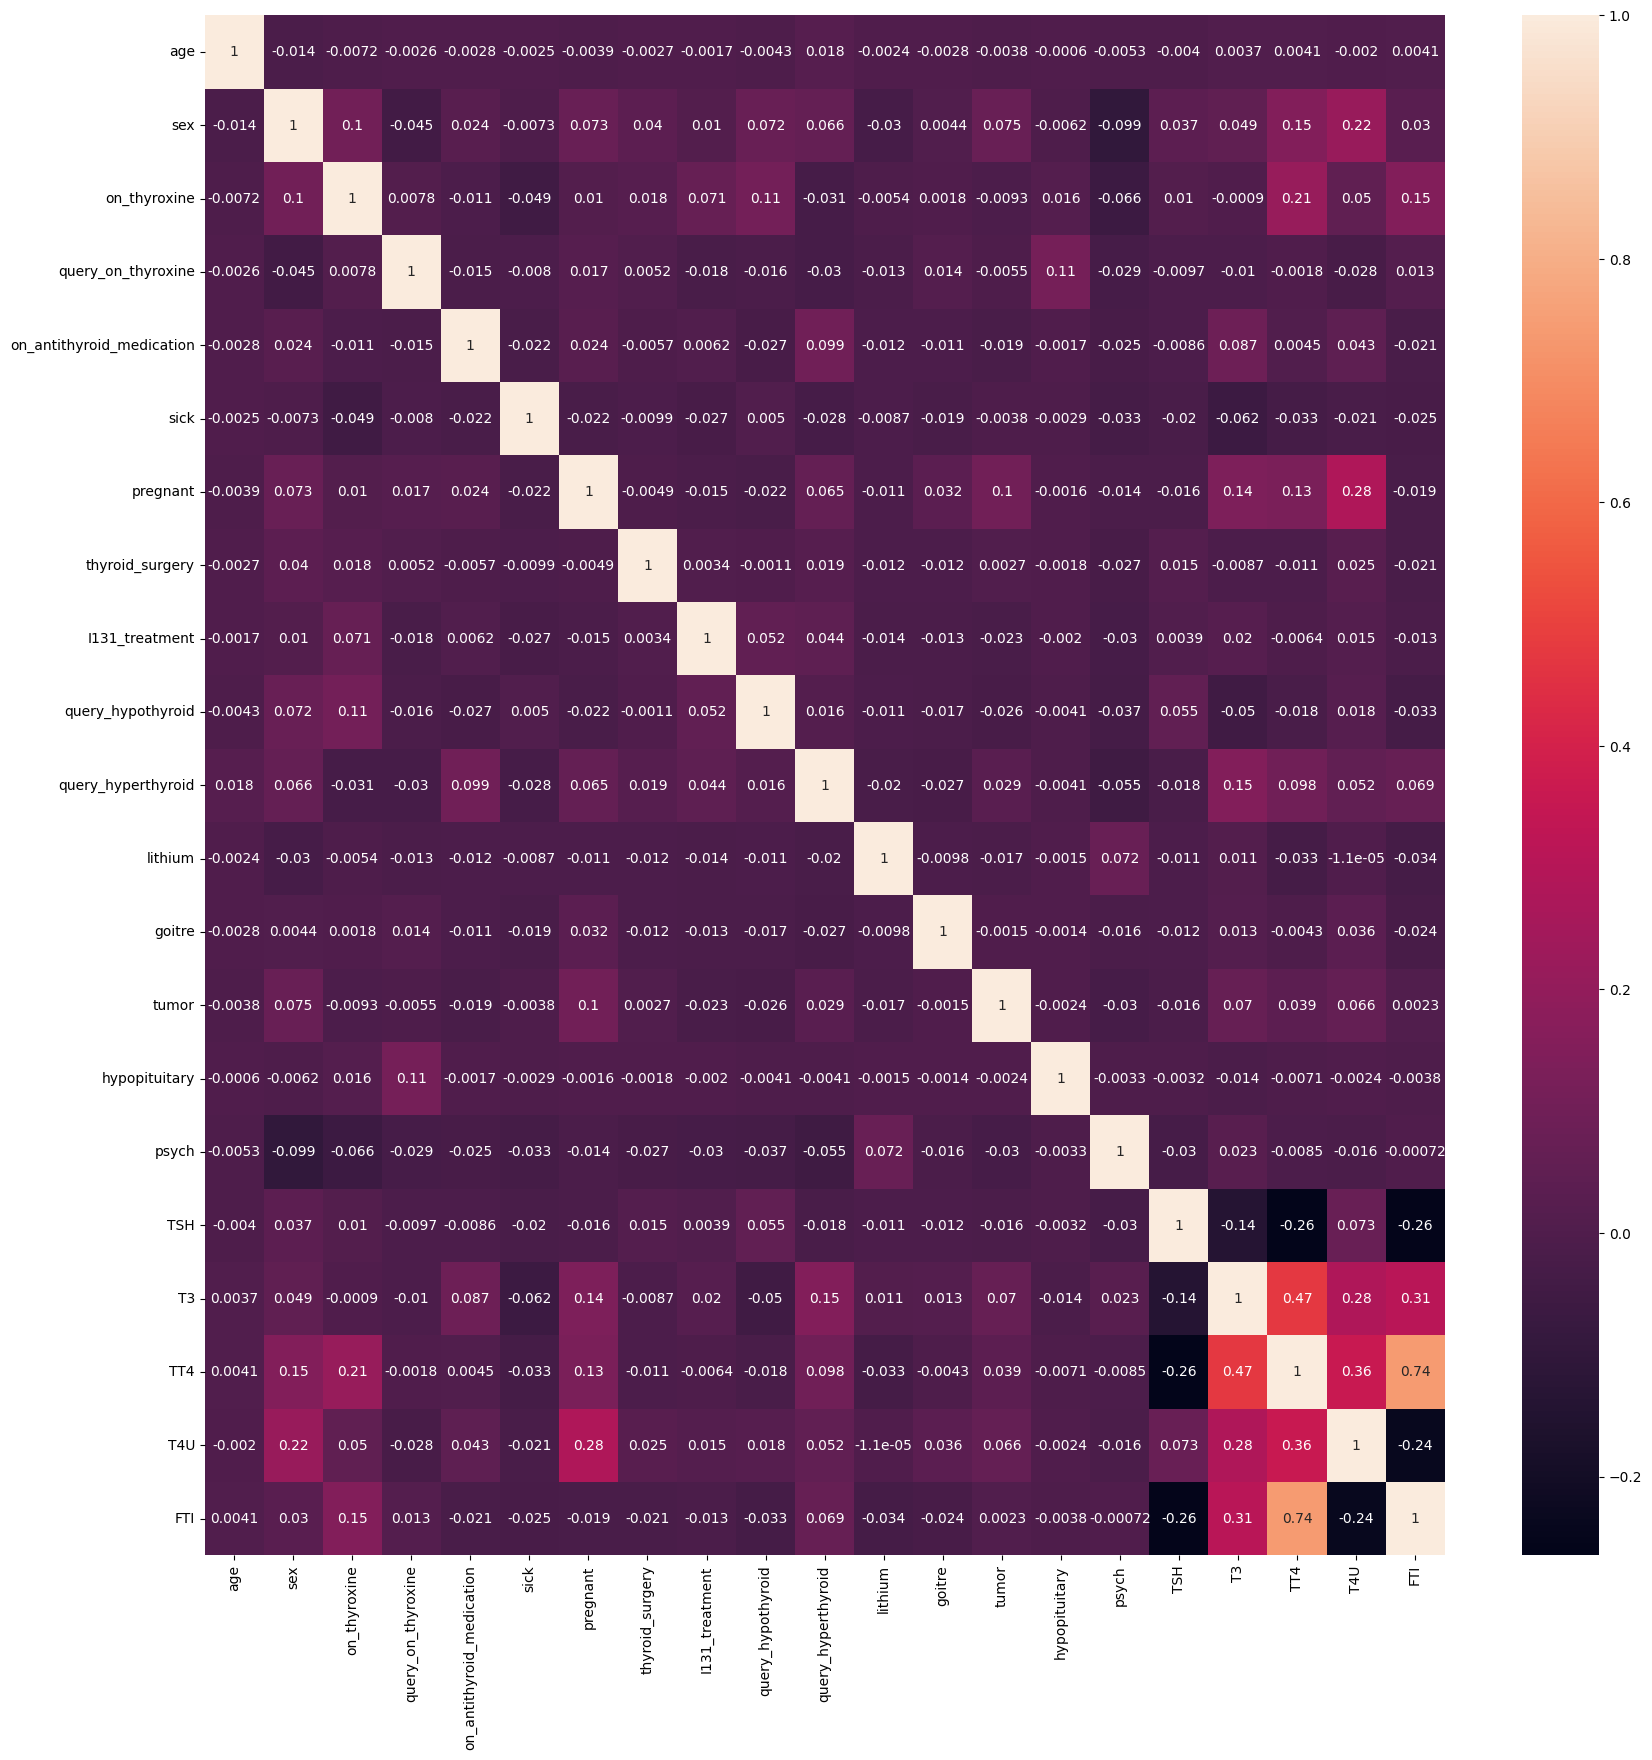

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(df.toPandas().corr(),annot=True)

Reprezentarea influentiei T3 si TSH.
Există o relație inversă între TSH și T3. Atunci când nivelul T3 este scăzut în sânge, glanda hipofiza eliberează mai mult TSH pentru a stimula glanda tiroidă să producă și să elibereze mai mult T3.

<Axes: xlabel='T3'>

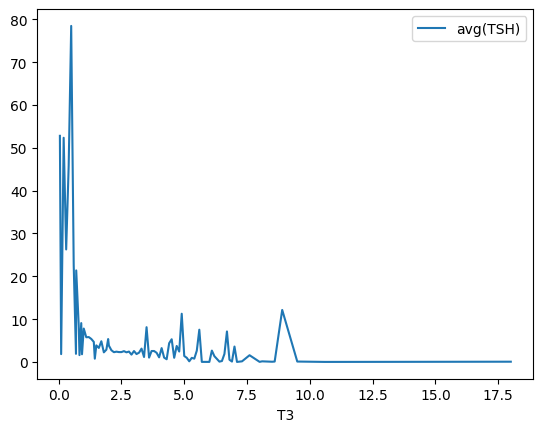

In [29]:
grouped = df.groupBy(df.T3).mean().sort("T3")
grouped.toPandas().plot(x="T3", y=["avg(TSH)"])

Afisati varsta medie a femeilor care au suferit o interventie chirurgicala si au valoarea TSH-ului intre 0.5 si 5.2 (limitele normale)

In [30]:
df_data.createOrReplaceTempView("th_disease")
queryDF = spark.sql("""
      SELECT avg(age)
      FROM th_disease
      WHERE sex = 2 and thyroid_surgery = 1 and ( TSH  BETWEEN 0.5 and 5.2)
""")
queryDF.show()

+------------------+
|          avg(age)|
+------------------+
|53.301886792452834|
+------------------+



Afisati care dintre cele doua categorii, barbati sau femei, au predispozitie sa sufere o interventie chirurgicala asupra glandei tiroide, inainte de varsta de 50 de ani.

In [31]:
queryDF = spark.sql("""
    WITH max_count AS (
        SELECT COUNT(*) AS max_count
        FROM th_disease
        WHERE thyroid_surgery = 1 and age <= 50
        GROUP BY sex
        ORDER BY COUNT(*) DESC
        LIMIT 1
    )
    SELECT sex
    FROM th_disease
    WHERE thyroid_surgery = 1 and age <= 50
    GROUP BY sex
    HAVING COUNT(*) = (SELECT max_count FROM max_count)
""")
queryDF.show()

+---+
|sex|
+---+
|2.0|
+---+



**III. Spark MLlib pentru clasificari si regresii**

In [32]:
df_data.describe

<bound method DataFrame.describe of DataFrame[age: float, sex: double, on_thyroxine: int, query_on_thyroxine: int, on_antithyroid_medication: int, sick: int, pregnant: int, thyroid_surgery: int, I131_treatment: int, query_hypothyroid: int, query_hyperthyroid: int, lithium: int, goitre: int, tumor: int, hypopituitary: int, psych: int, TSH: float, T3: float, TT4: float, T4U: float, FTI: float, tag_id: int]>

Transformarea coloanelor de caracteristici în una singura.

In [33]:
columns = df_data.columns
columns.remove('tag_id')
va = VectorAssembler(inputCols = columns, outputCol='features')
df_data = va.transform(df_data)

Datele se vor scala cu ajutorul ***StandardScaler***.

In [34]:
sc = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
sc_model = sc.fit(df_data)
df_data = sc_model.transform(df_data)

In [35]:
df_data.columns

['age',
 'sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI',
 'tag_id',
 'features',
 'scaledFeatures']

In [36]:
df_data.describe

<bound method DataFrame.describe of DataFrame[age: float, sex: double, on_thyroxine: int, query_on_thyroxine: int, on_antithyroid_medication: int, sick: int, pregnant: int, thyroid_surgery: int, I131_treatment: int, query_hypothyroid: int, query_hyperthyroid: int, lithium: int, goitre: int, tumor: int, hypopituitary: int, psych: int, TSH: float, T3: float, TT4: float, T4U: float, FTI: float, tag_id: int, features: vector, scaledFeatures: vector]>

Se vor separa datele astfel incat 70% dintre acestea vor fi date de antrenare(train), iar 30% dintre acestea date de test.

In [37]:
train, test = df_data.select('scaledFeatures', 'tag_id').randomSplit([0.7, 0.3], seed=23)

**a. Regresie logistica**

Vom crea un  model folosind ***LogisticRegression()*** importat din "pyspark.ml.classification", pe care il vom antrena pe datele de antrenare si il vom testa pe cele de test. La final evaluam predictia obtinuta.

In [38]:
lr = LogisticRegression(featuresCol='scaledFeatures',labelCol='tag_id', family='multinomial')
lr_model=lr.fit(train)

In [39]:
pred = lr_model.evaluate(test).predictions
pred.show()

+--------------------+------+--------------------+--------------------+----------+
|      scaledFeatures|tag_id|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(21,[0,1,2,3,5,16...|     8|[-5.0221325696329...|[4.49442961830902...|       8.0|
|(21,[0,1,2,3,12,1...|     8|[-4.6248257845706...|[3.45818613633654...|       8.0|
|(21,[0,1,2,3,16,1...|     5|[-4.9439003658268...|[4.01531562715950...|       5.0|
|(21,[0,1,2,3,16,1...|     5|[-4.9336056021730...|[1.37539281419390...|       5.0|
|(21,[0,1,2,3,16,1...|     8|[-4.9433176580863...|[3.60965311647754...|       8.0|
|(21,[0,1,2,3,16,1...|     8|[-4.8986754433881...|[5.07187909325799...|       8.0|
|(21,[0,1,2,3,16,1...|     5|[-4.9853042252164...|[1.37628342386262...|       5.0|
|(21,[0,1,2,3,16,1...|     5|[-4.9503885481813...|[2.43855834860142...|       5.0|
|(21,[0,1,2,4,16,1...|     8|[-5.1032717810322...|[1.33373558000271...|       8.0|
|(21

In [40]:
pred = pred.select('tag_id', 'prediction')
pred.show()

+------+----------+
|tag_id|prediction|
+------+----------+
|     8|       8.0|
|     8|       8.0|
|     5|       5.0|
|     5|       5.0|
|     8|       8.0|
|     8|       8.0|
|     5|       5.0|
|     5|       5.0|
|     8|       8.0|
|     8|       8.0|
|     6|       5.0|
|     5|       5.0|
|     1|       8.0|
|     8|       8.0|
|     8|       8.0|
|     5|       8.0|
|     2|       2.0|
|     8|       8.0|
|     8|       8.0|
|     3|       8.0|
+------+----------+
only showing top 20 rows



Pentru a evalua predictia obtinuta, vom folosi ***MulticlassClassificationEvaluator()***.

In [41]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='tag_id',
                                             metricName='accuracy')
evaluator.evaluate(pred)

0.855056589996349

b. **Random Forest**

Vom crea un model folosind ***RandomForestClassifier()*** importat din "pyspark.ml.classification", pe care il vom antrena pe datele de antrenare si il vom testa pe cele de test. La final evaluam predictia obtinuta.

In [42]:
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='tag_id', predictionCol='prediction', numTrees=10, seed=42)
rf_model = rf.fit(train)
pred = rf_model.evaluate(test).predictions
pred.show()
evaluator.evaluate(pred)

+--------------------+------+--------------------+--------------------+----------+
|      scaledFeatures|tag_id|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(21,[0,1,2,3,5,16...|     8|[0.0,0.0507811727...|[0.0,0.0050781172...|       8.0|
|(21,[0,1,2,3,12,1...|     8|[0.0,0.0493698934...|[0.0,0.0049369893...|       8.0|
|(21,[0,1,2,3,16,1...|     5|[0.0,0.0056588520...|[0.0,5.6588520614...|       5.0|
|(21,[0,1,2,3,16,1...|     5|[0.0,0.0056588520...|[0.0,5.6588520614...|       5.0|
|(21,[0,1,2,3,16,1...|     8|[0.0,0.0507811727...|[0.0,0.0050781172...|       8.0|
|(21,[0,1,2,3,16,1...|     8|[0.0,0.0493698934...|[0.0,0.0049369893...|       8.0|
|(21,[0,1,2,3,16,1...|     5|[0.0,0.5075561207...|[0.0,0.0507556120...|       5.0|
|(21,[0,1,2,3,16,1...|     5|[0.0,0.2167533483...|[0.0,0.0216753348...|       8.0|
|(21,[0,1,2,4,16,1...|     8|[0.0,0.0961642963...|[0.0,0.0096164296...|       8.0|
|(21

0.899963490324936

c. Optimizarea hiperparametrilor pentru Random Forest.

Pentru a realiza acest lucru, mai intai am creat un clasificator folosind RandomForestClassifier, apoi am definit o grila de posibili parametri pentru *numTree*. Am folosit **CrossValidator** ( validarea incrucisata) pentru a gasi cel mai bun model, apoi l-am aplicat pe datele de test și am evaluat acuratetea predictiei.

In [43]:
# rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='tag_id', predictionCol='prediction')
# paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [5,10]).build()
# cross_validator = CrossValidator(estimator=rf,
#                                 estimatorParamMaps=paramGrid,
#                                 evaluator=evaluator,
#                                 numFolds=2,
#                                 seed=42 )
# # antrenam croos_validator pe datele de antrenare, apoi alegem cel mai bun model
# cv_model = cross_validator.fit(train)
# rf_best_model = cv_model.bestModel
# pred = rf_best_model.transform(test)
# pred.show()
# evaluator.evaluate(pred)

**IV.Utilizarea unui Data Pipeline**

In [44]:
df_data.describe

<bound method DataFrame.describe of DataFrame[age: float, sex: double, on_thyroxine: int, query_on_thyroxine: int, on_antithyroid_medication: int, sick: int, pregnant: int, thyroid_surgery: int, I131_treatment: int, query_hypothyroid: int, query_hyperthyroid: int, lithium: int, goitre: int, tumor: int, hypopituitary: int, psych: int, TSH: float, T3: float, TT4: float, T4U: float, FTI: float, tag_id: int, features: vector, scaledFeatures: vector]>

In [45]:
# adaugarea in pipeline a va, scalerului si a modelului rf
pipeline = Pipeline(stages=[va, sc, rf])
df_data = df_data.drop('features', 'scaledFeatures')
# impartirea setului de date in antrenare si test
train, test = df_data.randomSplit([0.7, 0.3], seed=23)

In [46]:
fitted_model = pipeline.fit(train)
pred = fitted_model.transform(test)
pred.select('tag_id', 'prediction').show()
evaluator.evaluate(pred)

+------+----------+
|tag_id|prediction|
+------+----------+
|     8|       8.0|
|     3|       1.0|
|     2|       2.0|
|     8|       8.0|
|     2|       2.0|
|     2|       2.0|
|     8|       2.0|
|     3|       1.0|
|     8|       8.0|
|     5|       5.0|
|     8|       8.0|
|     8|       8.0|
|     5|       5.0|
|     8|       8.0|
|     8|       8.0|
|     8|       8.0|
|     8|       8.0|
|     1|       8.0|
|     8|       8.0|
|     8|       8.0|
+------+----------+
only showing top 20 rows



0.8919313618108798

In [47]:
df = df_data

**V. Aplicarea unei metode de Deep Learning**

Am importat librariile de care aveam nevoie, dupa care am pus într-un vector separat coloana corespunzatoare claselor. Am împărțit datele în procent de 70% pentru cele de antrenare și 30% pentru cele de test folosind metoda **train_test_split()**. Unlterior am tranformat datele in date categorice.

In [ ]:
# !pip install --upgrade tensorflow

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD,Adam

from tensorflow.keras.metrics import CategoricalAccuracy
from pyspark.sql.functions import col

In [ ]:
df_data = df_data.drop("features", "scaledFeatures")

In [ ]:
X = df_data.drop('tag_id').toPandas()
y = df_data.select('tag_id').toPandas()

In [ ]:
df_data.describe

<bound method DataFrame.describe of DataFrame[age: float, sex: double, on_thyroxine: int, query_on_thyroxine: int, on_antithyroid_medication: int, sick: int, pregnant: int, thyroid_surgery: int, I131_treatment: int, query_hypothyroid: int, query_hyperthyroid: int, lithium: int, goitre: int, tumor: int, hypopituitary: int, psych: int, TSH: float, T3: float, TT4: float, T4U: float, FTI: float, tag_id: int]>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)


In [ ]:
num_classes = len(np.unique(y_train['tag_id'].to_numpy()))
num_classes

8

In [ ]:
y_train = to_categorical(y_train['tag_id'].to_numpy(), num_classes= 9)
y_test = to_categorical(y_test['tag_id'].to_numpy(), num_classes=9)

In [ ]:
y.shape[0]

Am utilizat un model secvențial. Mai întai este adăugat un strat de intrare, InputLayer, care specifică forma datelor de intrare în rețeaua neurală, în cazul de față avem 21 de caracteristici. A urmat adăugarea a patru layere cu funcția de activare* Relu*, alegând număr variabil de neuroni. La final am adăugat un layer de ieșire cu activare *softmax* pentru a obține probabilitățile celor 8 clase.
În urma mai multor teste, pentru optimizare am ales SGD iar numărul de epoci este de  100 . La final am evaluat predicția.

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(21,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(9, activation="softmax"))

model.summary()
model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=100)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 100)               2200      
                                                                 
 dense_168 (Dense)           (None, 50)                5050      
                                                                 
 dense_169 (Dense)           (None, 28)                1428      
                                                                 
 dense_170 (Dense)           (None, 14)                406       
                                                                 
 dense_171 (Dense)           (None, 9)                 135       
                                                                 
Total params: 9,219
Trainable params: 9,219
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
95/95 [==============================] 

In [ ]:
preds = model.predict(X_test)

94/94 [==============================] - 0s 1ms/step


In [ ]:
m = CategoricalAccuracy()
m.update_state(y_test, preds)
m.result().numpy()

0.8659759

**VI. Folosirea Spark Streaming**

In [ ]:
df.show()
df.write.csv("/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/thyroid_disease.csv", header=True, mode= "overwrite")

+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+-----+----+-----+------+
| age|sex|on_thyroxine|query_on_thyroxine|on_antithyroid_medication|sick|pregnant|thyroid_surgery|I131_treatment|query_hypothyroid|query_hyperthyroid|lithium|goitre|tumor|hypopituitary|psych|     TSH|       T3|  TT4| T4U|  FTI|tag_id|
+----+---+------------+------------------+-------------------------+----+--------+---------------+--------------+-----------------+------------------+-------+------+-----+-------------+-----+--------+---------+-----+----+-----+------+
|41.0|2.0|           0|                 0|                        0|   0|       0|              0|             0|                0|                 0|      0|     0|    0|            0|    0|   140.0|1.9706289| 33.0|1.07| 31.0|     2|
|41.0|2.0|           0|                 0|                  

In [48]:
def f(x):
    d = {}
    for i in range(len(x)):
        d[columns[i]] = x[i]
    return d

def p_stream(time, record):
    print(f"===== {time} =====")
    try:
        df = record.map(lambda x: Row(**f(x))).toDF()
        pred = fitted_model.transform(df).select(["tag_id", "prediction"])
        pred.show(pred.count(), False)
        #pred.write.mode("append").csv('/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/thyroid_prediction.csv')
    except Exception as e:
        print(e)

In [49]:

test.toPandas().to_csv("/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/thyroid.csv", index=False, header=False)

In [50]:
ssc = StreamingContext(spark.sparkContext, 3)
lines = ssc.textFileStream('/content/drive/MyDrive/MASTER_FMI/Colab_Notebooks/Data/')
rows = lines.map(lambda line: [float(x) for x in line.split(",")])
rows.foreachRDD(p_stream)

/usr/local/lib/python3.10/dist-packages/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


In [ ]:
 ssc.start()
ssc.awaitTermination()

===== 2023-06-20 20:43:03 =====
RDD is empty
===== 2023-06-20 20:43:06 =====
RDD is empty
===== 2023-06-20 20:43:09 =====
RDD is empty
===== 2023-06-20 20:43:12 =====
RDD is empty
===== 2023-06-20 20:43:15 =====
RDD is empty
===== 2023-06-20 20:43:18 =====
RDD is empty
===== 2023-06-20 20:43:21 =====
RDD is empty
===== 2023-06-20 20:43:24 =====
RDD is empty
===== 2023-06-20 20:43:27 =====
RDD is empty
===== 2023-06-20 20:43:30 =====
RDD is empty
===== 2023-06-20 20:43:33 =====
RDD is empty
===== 2023-06-20 20:43:36 =====
RDD is empty
===== 2023-06-20 20:43:39 =====
RDD is empty
===== 2023-06-20 20:43:42 =====
RDD is empty
===== 2023-06-20 20:43:45 =====
RDD is empty
===== 2023-06-20 20:43:48 =====
RDD is empty
===== 2023-06-20 20:43:51 =====
RDD is empty
===== 2023-06-20 20:43:54 =====
RDD is empty
===== 2023-06-20 20:43:57 =====
RDD is empty
===== 2023-06-20 20:44:00 =====
RDD is empty
===== 2023-06-20 20:44:03 =====
RDD is empty
===== 2023-06-20 20:44:06 =====
RDD is empty
===== 2023

In [ ]:
ssc.terminate()

In [ ]:
ssc.stop()

In [ ]:
import os
os.kill(os.getpid(), 9)